## Clickbait spoiling notebook

In [219]:
# Data processing
import pandas as pd
import string
import re
import json
import torch
import numpy as np

# OpenAI connection
import os
from dotenv import load_dotenv
from openai import OpenAI
import tiktoken
from typing import List

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer, BertForMaskedLM, BertModel
from bert_score import BERTScorer

In [62]:
# VARIABLES
load_dotenv()
api_key = os.getenv("OPEN_AI_KEY")
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wojom\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\wojom\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [63]:
def calculate_cost(prompt: str, data: str, out: str, model: str = "gpt-4o-mini") -> float:
    """
    Calculates the cost of a request to a OPEN AI model based on the prompt, data, and output

    Args:
        prompt (str): prompt sent to the LLM
        data (str): additional data sent to the LLM.
        out (str): response received from the LLM.
        model (str): model identifier used to determine the tokenizer, defaults to "gpt-4o-mini"

    Returns:
        float: total cost of the tokens used in USD
    """
    tokenizer = tiktoken.encoding_for_model(model)  
    request = str(prompt) + str(data)
    response = str(out)

    request_tokens = tokenizer.encode(request)
    response_tokens = tokenizer.encode(response)

    input_tokens = len(request_tokens)
    output_tokens = len(response_tokens)

    # costs per 1 million tokens
    cost_per_1M_input_tokens = 0.15  # $0.15 per 1M input tokens
    cost_per_1M_output_tokens = 0.60  # $0.60 per 1M output tokens

    input_cost = (input_tokens / 10**6) * cost_per_1M_input_tokens
    output_cost = (output_tokens / 10**6) * cost_per_1M_output_tokens
    total_cost = input_cost + output_cost

    print(f"Input tokens: {input_tokens}")
    print(f"Output tokens: {output_tokens}")
    print(f"Total tokens: {input_tokens + output_tokens}")
    print(f"Cost: ${total_cost:.5f}")
    return total_cost

In [64]:
spoil_df = pd.read_csv("../data/spoiling_data.csv")
print(spoil_df.shape)
tags = spoil_df["tags"].unique().tolist()
print(tags)

(3358, 6)
['passage', 'phrase', 'multi']


In [65]:
client = OpenAI(api_key=api_key)

In [66]:
spoil_df["paragraphsLength"] = spoil_df["targetParagraphs"].apply(lambda x: len(x))
mean_length = spoil_df["paragraphsLength"].mean()
median_length = spoil_df["paragraphsLength"].median()

print("Mean length of the paragraph:", mean_length)
print("Median length of the paragraph:", median_length)

Mean length of the paragraph: 2868.0226325193566
Median length of the paragraph: 1973.0


### Direct Prompt

In [67]:
spoil_df[spoil_df["paragraphsLength"] == min(spoil_df["paragraphsLength"])]

,targetTitle,targetParagraphs,humanSpoiler,spoiler,tags,spoilerPositions,paragraphsLength
696,The Grand Tour launch date,November 18 The Grand Tour: Launch Date,November 18,November 18,phrase,"[[[0, 0], [0, 11]]]",39


In [68]:
spoil_df["tags"].unique().tolist()

['passage', 'phrase', 'multi']

In [88]:
pd.set_option('display.max_colwidth', None)
examples = {}
tags = spoil_df["tags"].unique()

for tag in tags:
    spoiler = spoil_df.loc[(spoil_df["tags"] == tag) & (spoil_df["paragraphsLength"] < 1000)].iloc[0]
    examples[tag] = {
        "tag": spoiler["tags"],
        "spoiler": spoiler["spoiler"],
        "title": spoiler["targetTitle"],
        "paragraph": spoiler["targetParagraphs"],
        "human_spoiler": spoiler["humanSpoiler"],
        "length": spoiler["paragraphsLength"]
    }


print(examples["passage"]["spoiler"])
pd.set_option('display.max_colwidth', 50)

rainbow colours in the sky and a halo spanning 360 degrees


In [87]:
for key in examples:
    print(key)

passage
phrase
multi


In [71]:
prompt = """
You are a model designed to generate concise spoilers from articles. Your task is to analyze the main question or topic posed by the article’s title and generate a spoiler based on the content provided in the article's parahraphs. Your response must include a JSON object with keys "humanSpoiler", and "spoiler".
Use "targetTitle" to determine the central question or topic the spoiler should address. Review "targetParagraphs" to find the most relevant details that directly answer or the topic stated in the title. Consider provided tag: 
"phrase": Short, direct answer or single phrase.
"passage": More detailed, informative spoiler.
"multi": Multiple sentences or complex information for a full response, provide a longer, structured spoiler.

Answer:{
"humanSpoiler": <A model-generated spoiler>,
"spoiler": <A concise, extracted from the article’s content but remaining logical>
}

Example 1:
Input{ 
"tag":"phrase"
"targetTitle":"Teen Mom 2 Star Jenelle Evans Reveals Sex Of Her Second Child"
"targetParagraphs":"Teen Mom 2 star Jenelle Evans took to Twitter and Instagram Monday (Feb. 3) to announce that she and boyfriend Nathan Griffin are expecting a baby boy., Evans has faced criticism for the pregnancy, largely because she does not currently have custody of her first child, 4-year-old Jace. In the Season 5 premiere of Teen Mom 2, Evans had an abortion, which led to even more speculation about whether or not she is ready to have a second child. The reality TV star has a long history battling drug addiction, and has been arrested several times., Evans told In Touch that she had the abortion at the beginning of Season 5 because she was too skinny and unhealthy to continue with the unexpected pregnancy while in recovery for heroin addiction., Evans is legally married to Courtland Rogers, though the couple is separated. The father of her first son, Jace, is ex-boyfriend Andrew Lewis."}
Output{
"humanSpoiler":"Boy"
"spoiler":"boy"}

Example 2:
Input{
"tag":"passage"
"targetTitle":"You’ll Never Believe What This Family Saw in the Sky Outside Their House in Finland."
"targetParagraphs":"It was cold and very foggy, the temperature was around -10 degrees Celsius, said Hänninen. When the clouds began to break, there were rainbow colours in the sky and a halo spanning 360 degrees! It was worth taking a picture or two. If I ever stepped outside and saw this in my backyard, I might think the aliens were invading!"}
Output{
"humanSpoiler":"Sun Halos Which are caused by ice crystals in cirrostratus clouds."
"spoiler":"rainbow colours in the sky and a halo spanning 360 degrees"}

Example 2:
Input{
"tag":"multi"
"targetTitle":"Mixing These Two Common Medications Could Be Life-Threatening"
"targetParagraphs":"It’s common knowledge that mixing your medication isn’t recommended without a doctor’s permission. However, an estimated 1 million people in the United States are on two drugs that together can cause a seriously adverse reaction., This video from Business Insider recalls a study from Harvard, Stanford, and Vanderbilt University on a specific drug interaction. Their study looked at the interaction between pravastatin – a cholesterol-reducing drug – and paroxetine, a widely used antidepressant known under the brand name of Seroxat. If taken together, they can cause complications that are so severe, they could become life-threatening., Watch the video below to find out why."}
Output{
"humanSpoiler":"Pravastatin and Paroxetine (AKA Seroxat) iflscience.com"
"spoiler":"pravastatin, paroxetine"}
"""

In [72]:
cost_of_one = calculate_cost(prompt=prompt, data="", out="Intellectual stimulation")
print(f"Total cost: ${cost_of_one * 4000}")

Input tokens: 776
Output tokens: 3
Total tokens: 779
Cost: $0.00012
Total cost: $0.4728


In [73]:
def sample_test_df(df, types_of_spoilers, num_samples, random_state=1):
    samples = []
    for tag in types_of_spoilers:
        sample = df[df['tags'] == tag].sample(num_samples, random_state=random_state)
        samples.append(sample)
    test_df = pd.concat(samples).reset_index(drop=True)
    return test_df

In [74]:
test_df = sample_test_df(spoil_df, types_of_spoilers=['passage', 'phrase', 'multi'], num_samples=10, random_state=1)
test_df.shape

(30, 7)

### Call to the OpenAI. Response saved as file

In [75]:
def create_batch_request_to_open_ai_direct_prompt(
    list_of_prompts: List[str],
    name_of_request_file: str,
    description_of_request: str,   
    temperature: None = 1, #between [0,2]. Default = 1, higher temperature leads to more random, while lower to more deterministic,
    model: str = "gpt-4o-mini"
):

    dictionary = [{
        "custom_id": f"request{i}", 
        "method": "POST", 
        "url": "/v1/chat/completions", 
        "body": {"model": model, 
                 "messages": [
                     {"role": "system", "content": "assistant"},
                     {"role": "user", "content": prompt__}],
                 "max_tokens": 1000,
                 "temperature": temperature}
    } for i, prompt__ in enumerate(list_of_prompts)]
    
    with open(f"../request_files_openai/{name_of_request_file}.jsonl", "w") as outfile:
        for request__ in dictionary:
            json.dump(request__, outfile)
            outfile.write('\n')
    
    
    batch_input_file = client.files.create(
      file=open(fr"../request_files_openai/{name_of_request_file}.jsonl", "rb"),
      purpose="batch"
    )
    
    return client.batches.create(
        input_file_id=batch_input_file.id,
        endpoint="/v1/chat/completions",
        completion_window="24h",
        metadata={
          "description": description_of_request
        }
    )

In [76]:
def save_direct_prompt_to_file_and_get_predictions(
    result_file_id: str,
    result_file_name: str,
    save_to_file: bool = True
):
    if save_to_file:
        result = client.files.content(result_file_id).content
        result_file_name = f"../request_files_openai/{result_file_name}.jsonl"
        
        with open(result_file_name, 'wb') as file:
            file.write(result)

    pred = []
    with open(result_file_name, 'r') as file:
        i = 0
        for line in file:
            prediction_str = json.loads(line)['response']['body']['choices'][0]['message']['content']
            try:
                pred.append(str(prediction_str))
            except Exception as e:
                print("there was problem with this request. Output:")
                print(prediction_str)
                print()
                pred.append(0)
                i+=1
    print(f"number of errors = {i}")
    return pred

In [77]:
prompt_1 = [
    str(prompt + f'Article to spoil: "tag":{entry["tags"]}. "targetTitle":{entry["targetTitle"]}. "targetParagraphs":{entry["targetParagraphs"]}')
    for _, entry in test_df.iterrows()
]

In [78]:
test_batch = create_batch_request_to_open_ai_direct_prompt(
    list_of_prompts = prompt_1,
    name_of_request_file = "request_spoiling_test_2",
    description_of_request = "request_spoiling_12_11_2024",
)

In [79]:
in_progress_batch = client.batches.retrieve(test_batch.id)
in_progress_batch.output_file_id

In [80]:
file_response = client.files.content(in_progress_batch.output_file_id).content
print(file_response)

ValueError: Expected a non-empty value for `file_id` but received None

In [ ]:
pred = save_direct_prompt_to_file_and_get_predictions(
    result_file_id = in_progress_batch.output_file_id,
    result_file_name = "spoiling_test_2"
)

number of errors = 0


### Spoiling analysis from file

In [207]:
result_file_name = "../request_files_openai/spoiling_test_2.jsonl"
pred = save_direct_prompt_to_file_and_get_predictions(
    result_file_id = None,
    result_file_name = result_file_name,
    save_to_file = False
)

number of errors = 0


In [208]:
def extract_data_regex(pred):
    pattern = r'[{}\n":,]'
    human_spoiler_pattern = r'"humanSpoiler"\s*:\s*"([^"]+)"'
    spoiler_pattern = r'"spoiler"\s*:\s*"([^"]+)"'
    data = []

    for text in pred:
        human_spoiler_value = spoiler_value = None
        human_spoiler_match = re.search(human_spoiler_pattern, text)
        spoiler_match = re.search(spoiler_pattern, text)
        if human_spoiler_match:
            human_spoiler_value = human_spoiler_match.group(1)
        else:
            match = re.search(r'humanSpoiler', text)
            if match:
                start_index = match.start()
                human_spoiler_value = text[start_index+12:] 
        
        if spoiler_match:
            spoiler_value = spoiler_match.group(1)
        else:
            match = re.search(r'spoiler', text)
            if match:
                start_index = match.start()
                spoiler_value = text[start_index+7:] 
        
        
        data.append({
            "humanSpoiler": human_spoiler_value,
            "spoiler": spoiler_value
        })

    df = pd.DataFrame(data)
    return df


In [209]:
def extract_data(pred):
    data = []
    for spoiler in pred:
        match = re.search(r'\{.*?\}', spoiler, re.DOTALL)
        if match:
            result = match.group(0)
            json_spoiler = json.loads(result)
            data.append({
                "humanSpoiler": json_spoiler["humanSpoiler"],
                "spoiler": json_spoiler["spoiler"]
            })
        else:
            print("No match found.")
    return pd.DataFrame(data)

In [210]:
extracted_df = extract_data(pred)
na_rows = extracted_df[extracted_df.isna().any(axis=1)]
print("Extracted data size: ", extracted_df.shape)
print("Rows with NaN values: ", na_rows.shape)

Extracted data size:  (30, 2)
Rows with NaN values:  (0, 2)


### Calculating metrics
- BLEU
- BERTScore (BSc)
- METEOR (MET)
- Cosine Similarity

In [233]:
extracted_df.rename(columns={'humanSpoiler': 'humanSpoiler_ext', 'spoiler': 'spoiler_ext'}, inplace=True)
test_df.rename(columns={'humanSpoiler': 'humanSpoiler_org', 'spoiler': 'spoiler_org'}, inplace=True)
metrics_df = pd.concat([test_df[['humanSpoiler_org', 'spoiler_org']], extracted_df[['humanSpoiler_ext', 'spoiler_ext']]], axis=1)

#### Cosine Similarity for spoiler, humanSpoiler

In [212]:
vectorizer = TfidfVectorizer()
def calculate_cosine_similarity_row(row, columns):
    tfidf_matrix = vectorizer.fit_transform([row[columns[0]], row[columns[1]]])
    cosine_sim = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]
    return cosine_sim

In [213]:
metrics_df['humanSpoiler_cos_sim'] = metrics_df.apply(calculate_cosine_similarity_row, axis=1, columns=['humanSpoiler_ext', 'humanSpoiler_org'])
metrics_df['spoiler_cos_sim'] = metrics_df.apply(calculate_cosine_similarity_row, axis=1, columns=['spoiler_ext', 'spoiler_org'])

In [238]:
def plotHistograms(df, columns, xlabels, titles, kde=False):
    number = len(columns)
    fig, axs = plt.subplots(1, number, figsize=(12, 5))

    for i in range(number):
        sns.histplot(metrics_df[columns[i]], bins=10, kde=kde, ax=axs[i], edgecolor="black")
        axs[i].set_xlabel(xlabels[i])
        axs[i].set_ylabel('Counts')
        axs[i].set_title(titles[i])
    plt.tight_layout()
    plt.show()

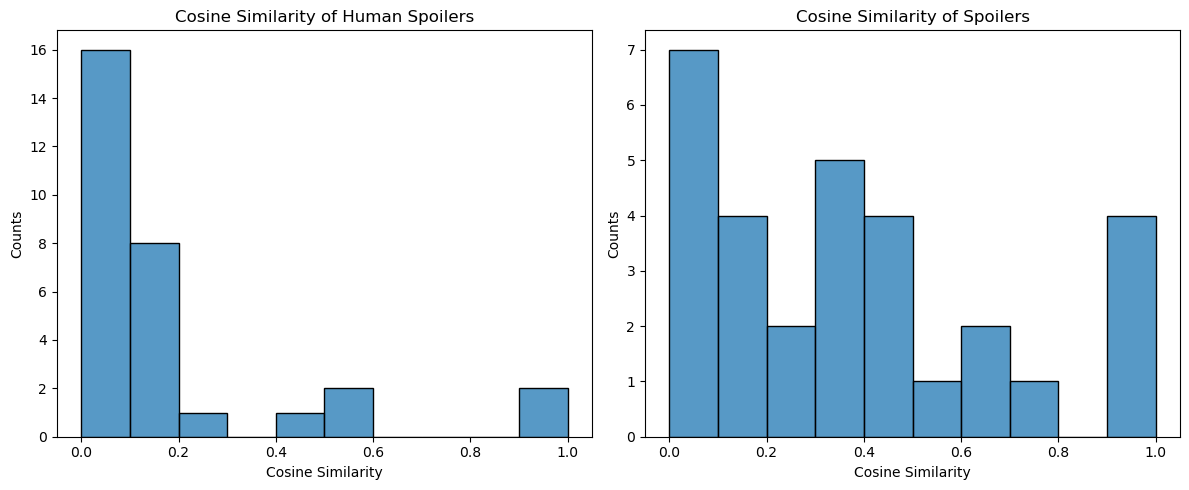

In [215]:
xlabels = ['Cosine Similarity', 'Cosine Similarity']
titles = ['Cosine Similarity of Human Spoilers', 'Cosine Similarity of Spoilers']
plotHistograms(metrics_df, columns=["humanSpoiler_cos_sim", "spoiler_cos_sim"], xlabels=xlabels, titles=titles)

In [216]:
print("Mean of humanSpoiler_cos_sim: ", metrics_df["humanSpoiler_cos_sim"].mean())
print("Mean of spoiler_cos_sim: ", metrics_df["spoiler_cos_sim"].mean())

Mean of humanSpoiler_cos_sim:  0.1697815297958982
Mean of spoiler_cos_sim:  0.37665756716320264


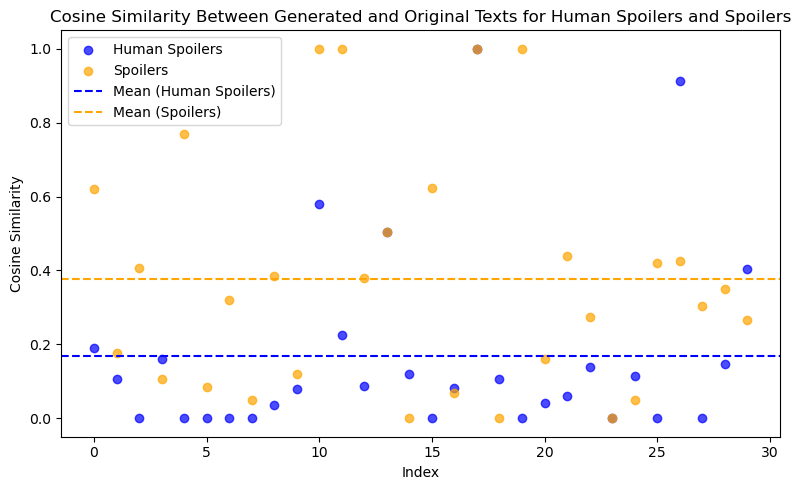

In [217]:
plt.figure(figsize=(8, 5))
# metrics_df.sort_values("spoiler_cos_sim", ascending=True, inplace=True)
human_spoiler_mean = metrics_df["humanSpoiler_cos_sim"].mean()
spoiler_mean = metrics_df["spoiler_cos_sim"].mean()
plt.scatter(
    range(len(metrics_df["humanSpoiler_cos_sim"])), 
    metrics_df["humanSpoiler_cos_sim"], 
    alpha=0.7, 
    color='blue', 
    label='Human Spoilers'
)


plt.scatter(
    range(len(metrics_df["spoiler_cos_sim"])), 
    metrics_df["spoiler_cos_sim"], 
    alpha=0.7, 
    color='orange', 
    label='Spoilers'
)

plt.axhline(y=human_spoiler_mean, color='blue', linestyle='--', label='Mean (Human Spoilers)')
plt.axhline(y=spoiler_mean, color='orange', linestyle='--', label='Mean (Spoilers)')

plt.xlabel('Index')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity Between Generated and Original Texts for Human Spoilers and Spoilers')
plt.legend()
plt.tight_layout()
plt.show()


In general, the model 'gpt-4o-mini' identifies paragraphs for extracting spoilers with higher mean value than the similarity of generated spoilers.

#### METEOR (MET) for spoiler, humanSpoiler
https://www.nltk.org/api/nltk.translate.meteor_score.html

In [179]:
def calculate_met_nltk(row, columns):
    tokenized_candidate = word_tokenize(row[columns[0]])
    tokenized_reference = word_tokenize(row[columns[1]])

    return meteor_score([tokenized_reference], tokenized_candidate)

In [180]:
metrics_df["humanSpoiler_met"] = metrics_df.apply(calculate_met_nltk, axis=1, columns=['humanSpoiler_ext', 'humanSpoiler_org'])
metrics_df['spoiler_met'] = metrics_df.apply(calculate_met_nltk, axis=1, columns=['spoiler_ext', 'spoiler_org'])

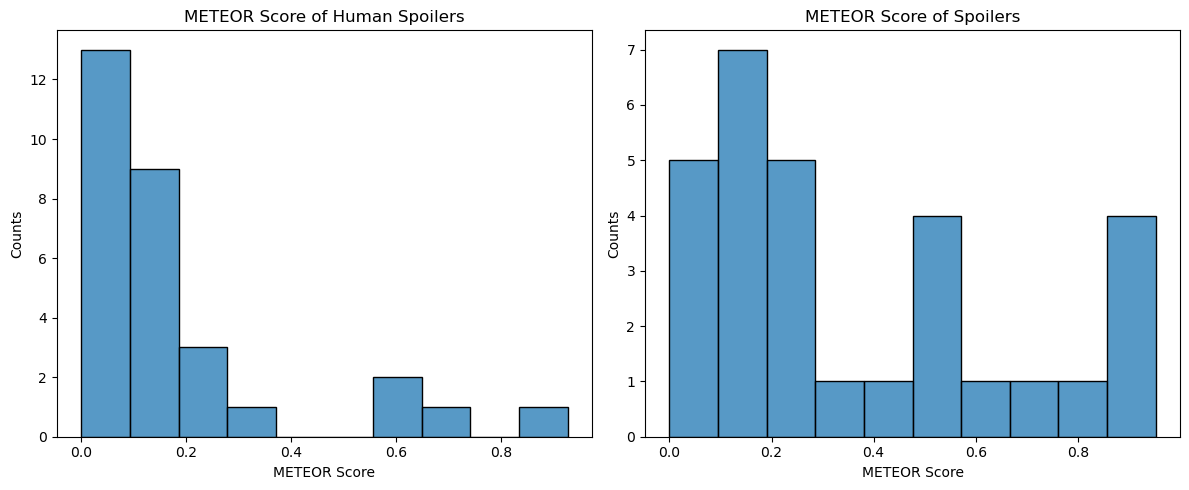

In [181]:
xlabels = ['METEOR Score','METEOR Score']
titles = ['METEOR Score of Human Spoilers','METEOR Score of Spoilers']
plotHistograms(metrics_df, columns=["humanSpoiler_met", "spoiler_met"], xlabels=xlabels, titles=titles)

In [182]:
print("Mean of humanSpoiler_met: ", metrics_df["humanSpoiler_met"].mean())
print("Mean of spoiler_met: ", metrics_df["spoiler_met"].mean())

Mean of humanSpoiler_met:  0.18517812122009714
Mean of spoiler_met:  0.37131659989018195


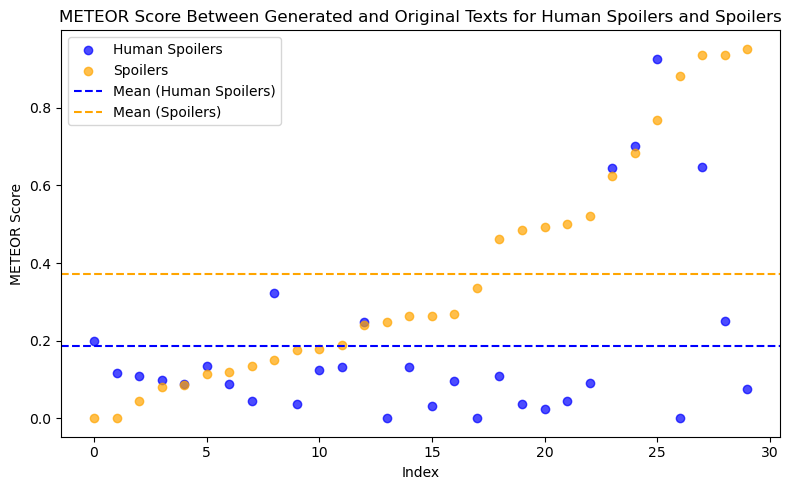

In [ ]:
plt.figure(figsize=(8, 5))
# metrics_df.sort_values("spoiler_met", ascending=True, inplace=True)
human_spoiler_mean = metrics_df["humanSpoiler_met"].mean()
spoiler_mean = metrics_df["spoiler_met"].mean()
plt.scatter(
    range(len(metrics_df["humanSpoiler_met"])), 
    metrics_df["humanSpoiler_met"], 
    alpha=0.7, 
    color='blue', 
    label='Human Spoilers'
)


plt.scatter(
    range(len(metrics_df["spoiler_met"])), 
    metrics_df["spoiler_met"], 
    alpha=0.7, 
    color='orange', 
    label='Spoilers'
)

plt.axhline(y=human_spoiler_mean, color='blue', linestyle='--', label='Mean (Human Spoilers)')
plt.axhline(y=spoiler_mean, color='orange', linestyle='--', label='Mean (Spoilers)')

plt.xlabel('Index')
plt.ylabel('METEOR Score')
plt.title('METEOR Score Between Generated and Original Texts for Human Spoilers and Spoilers')
plt.legend()
plt.tight_layout()
plt.show()

#### BLEU for spoiler, humanSpoiler
https://stackoverflow.com/questions/32395880/calculate-bleu-score-in-python

In [184]:
def calculate_bleu_nltk(row, columns):
    tokenized_candidate = word_tokenize(row[columns[0]])
    tokenized_reference = word_tokenize(row[columns[1]])
    smoothing_function = SmoothingFunction().method1
    
    return round(sentence_bleu(
        [tokenized_reference], 
        tokenized_candidate, 
        smoothing_function=smoothing_function, 
        weights=[0.40, 0.30, 0.20, 0.10]
        ), 3)

In [185]:
metrics_df["humanSpoiler_bleu"] = metrics_df.apply(calculate_bleu_nltk, axis=1, columns=['humanSpoiler_ext', 'humanSpoiler_org'])
metrics_df["spoiler_bleu"] = metrics_df.apply(calculate_bleu_nltk, axis=1, columns=['spoiler_ext', 'spoiler_org'])

In [186]:
print("Mean of humanSpoiler_bleu: ", metrics_df["humanSpoiler_bleu"].mean())
print("Mean of spoiler_bleu: ", metrics_df["spoiler_bleu"].mean())

Mean of humanSpoiler_bleu:  0.0768
Mean of spoiler_bleu:  0.13846666666666665


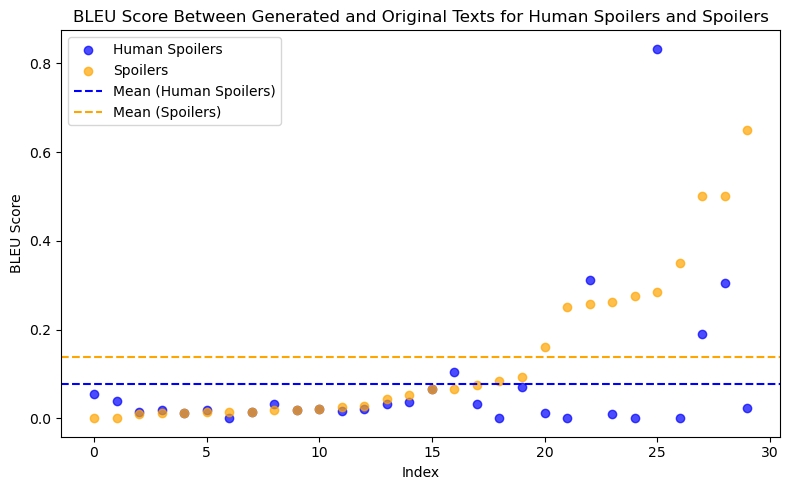

In [ ]:
plt.figure(figsize=(8, 5))
# metrics_df.sort_values("spoiler_bleu", ascending=True, inplace=True)
human_spoiler_mean = metrics_df["humanSpoiler_bleu"].mean()
spoiler_mean = metrics_df["spoiler_bleu"].mean()
plt.scatter(
    range(len(metrics_df["humanSpoiler_bleu"])), 
    metrics_df["humanSpoiler_bleu"], 
    alpha=0.7, 
    color='blue', 
    label='Human Spoilers'
)


plt.scatter(
    range(len(metrics_df["spoiler_bleu"])), 
    metrics_df["spoiler_bleu"], 
    alpha=0.7, 
    color='orange', 
    label='Spoilers'
)

plt.axhline(y=human_spoiler_mean, color='blue', linestyle='--', label='Mean (Human Spoilers)')
plt.axhline(y=spoiler_mean, color='orange', linestyle='--', label='Mean (Spoilers)')

plt.xlabel('Index')
plt.ylabel('BLEU Score')
plt.title('BLEU Score Between Generated and Original Texts for Human Spoilers and Spoilers')
plt.legend()
plt.tight_layout()
plt.show()

#### BERTScore (BSc) for spoiler, humanSpoiler
https://haticeozbolat17.medium.com/text-summarization-how-to-calculate-bertscore-771a51022964
https://rumn.medium.com/bert-score-explained-8f384d37bb06

In [ ]:
scorer = BERTScorer(model_type='bert-base-uncased', lang="en")

def calculate_bertscore(row, columns):
    P, R, F1 = scorer.score([row[columns[0]]], [row[columns[1]]])
    return P.mean().item(), R.mean().item(), F1.mean().item()

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

def calculate_bert_similarity(row, columns):
    embeddings = []
    for column in columns:
        text = row[column]
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        outputs = model(**inputs)
        # The mean of the last hidden state. Squeeze to remove batch dimension.
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
        embeddings.append(embedding)
    
    similarity = np.dot(embeddings[0], embeddings[1]) / (np.linalg.norm(embeddings[0]) * np.linalg.norm(embeddings[1]))
    return similarity

metrics_df["bertScore"] = metrics_df.apply(calculate_bert_similarity, columns=["humanSpoiler_org", "humanSpoiler_ext"], axis=1)


In [254]:
metrics_df[["hs_bert_precision", "hs_bert_recall", "hs_bert_f1"]] = metrics_df[["humanSpoiler_org", "humanSpoiler_ext"]].apply(calculate_bertscore, columns=["humanSpoiler_org", "humanSpoiler_ext"], axis=1, result_type="expand")
metrics_df[["s_bert_precision", "s_bert_recall", "s_bert_f1"]] = metrics_df[["spoiler_org", "spoiler_ext"]].apply(calculate_bertscore, columns=["spoiler_org", "spoiler_ext"], axis=1, result_type="expand")

In [ ]:
# niezbyt ladny wykres :(
metrics_long = metrics_df.melt(id_vars="index", value_vars=["hs_bert_precision", "s_bert_precision"], 
                               var_name="Line Type", value_name="Precision")
fig = px.line(
    metrics_long, 
    x="index", 
    y="Precision", 
    color="Line Type", 
    title="BERT Precision Comparison", 
    labels={"index": "Index", "Precision": "Precision"}
)

fig.update_layout(
    title_font_size=20,
    xaxis_title_font_size=16,
    yaxis_title_font_size=16,
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    template="plotly_white"
)

fig.show()

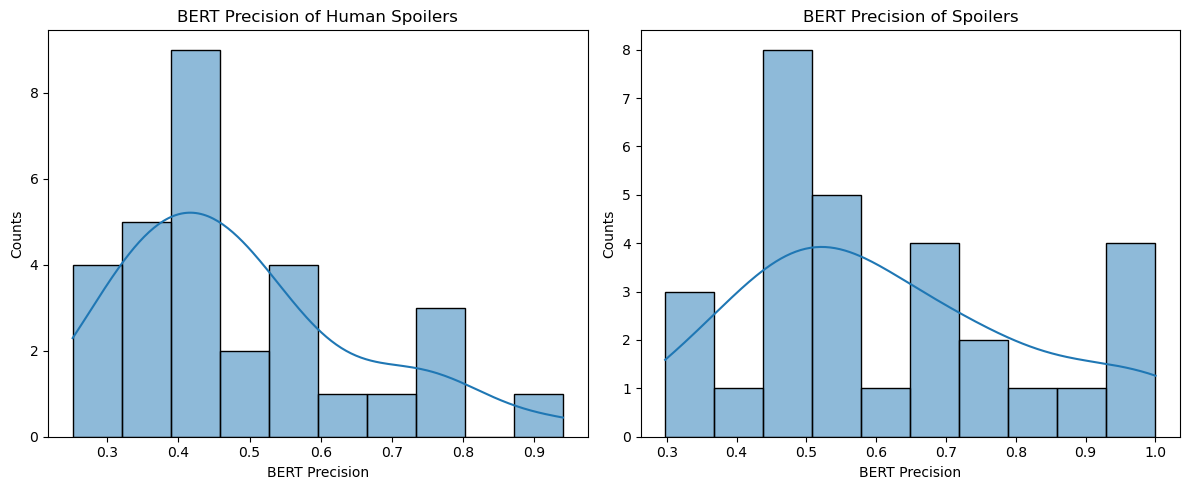

In [242]:
xlabels = ['BERT Precision','BERT Precision']
titles = ['BERT Precision of Human Spoilers','BERT Precision of Spoilers']
plotHistograms(metrics_df, columns=["hs_bert_precision", "s_bert_precision"], xlabels=xlabels, titles=titles, kde=True)

In [252]:
metrics_df["humanSpoiler_bertScore"] = metrics_df.apply(calculate_bert_similarity, columns=["humanSpoiler_org", "humanSpoiler_ext"], axis=1)
metrics_df["spoiler_bertScore"] = metrics_df.apply(calculate_bert_similarity, columns=["spoiler_org", "spoiler_ext"], axis=1)

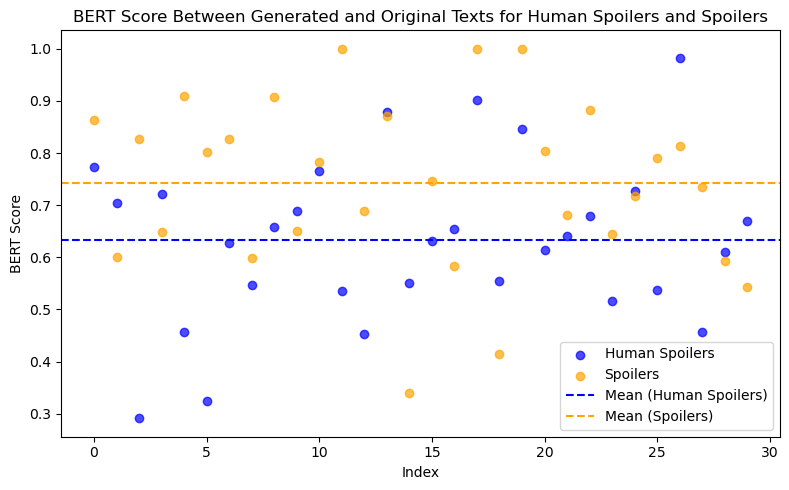

In [253]:
plt.figure(figsize=(8, 5))
# metrics_df.sort_values("spoiler_bleu", ascending=True, inplace=True)
human_spoiler_mean = metrics_df["humanSpoiler_bertScore"].mean()
spoiler_mean = metrics_df["spoiler_bertScore"].mean()
plt.scatter(
    range(len(metrics_df["humanSpoiler_bertScore"])), 
    metrics_df["humanSpoiler_bertScore"], 
    alpha=0.7, 
    color='blue', 
    label='Human Spoilers'
)


plt.scatter(
    range(len(metrics_df["spoiler_bertScore"])), 
    metrics_df["spoiler_bertScore"], 
    alpha=0.7, 
    color='orange', 
    label='Spoilers'
)

plt.axhline(y=human_spoiler_mean, color='blue', linestyle='--', label='Mean (Human Spoilers)')
plt.axhline(y=spoiler_mean, color='orange', linestyle='--', label='Mean (Spoilers)')

plt.xlabel('Index')
plt.ylabel('BERT Score')
plt.title('BERT Score Between Generated and Original Texts for Human Spoilers and Spoilers')
plt.legend()
plt.tight_layout()
plt.show()